# **Introduction to DeepSNAP Heterogeneous Graph**

This is an introduction tutorial on DeepSNAP heterogeneous graph. It contains an example that shows how to create and utilize the DeepSNAP heterogeneous graph. Then, we will go through that building a heterogeneous graph link prediction task using the DeepSNAP.

# Installation

Before running the cells, please go to the `Runtime` and `Change runtime type` to `GPU`.

In [1]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install -q deepsnap

1.11.0+cu113
     |████████████████████████████████| 7.9 MB 5.0 MB/s 
     |████████████████████████████████| 3.5 MB 4.0 MB/s 
     |████████████████████████████████| 68 kB 2.2 MB/s 


# Heterogeneous Graph in DeepSNAP

In this section, we will go through the basics of the DeepSNAP heterogeneous graph, such as the required or supported features.

## Heterogeneous Graph Features
* `node_feature`: The feature of each node (`torch.tensor`)
* `node_type`: The node type of each node (`string`)
* `edge_type`: The edge type of each edge (`string`)
* `node_label`: The label of each node (`int`)

Following is an example that transforms an graph into the format supported by DeepSNAP.

The example graph is the [karate club graph](https://networkx.github.io/documentation/stable/auto_examples/graph/plot_karate_club.html). Each node in the graph represents member in either club "Mr. Hi" or club "Officer".


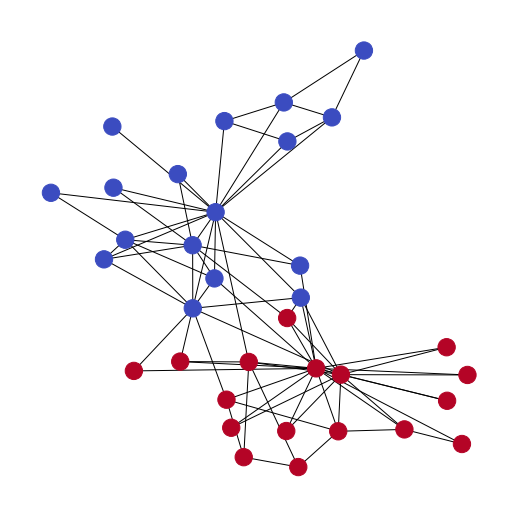

In [2]:
from pylab import *
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities
import matplotlib.pyplot as plt
import copy

G = nx.karate_club_graph()
community_map = {}
for node in G.nodes(data=True):
    if node[1]["club"] == "Mr. Hi":
        community_map[node[0]] = 0
    else:
        community_map[node[0]] = 1
node_color = []
color_map = {0: 0, 1: 1}
node_color = [color_map[community_map[node]] for node in G.nodes()]
pos = nx.spring_layout(G, seed=1)
plt.figure(figsize=(7, 7))
nx.draw(G, pos=pos, cmap=plt.get_cmap('coolwarm'), node_color=node_color)
show()

Since each node belongs to one of the two clubs, we treat the club as the `node_type`. Nodes in different clubs are assigned with different node types (`n0` or `n1`). In addition, we also assign three different types of `edge_type` to the edges, which include edges within each clubs (2 types) and edges across two clubs (1 type). Different types of nodes and edges are visualized in different colors. The NetworkX object `G` in following code can be transformed into `deepsnap.hetero_graph.HeteroGraph` directly.

(0, {'club': 'Mr. Hi', 'node_type': 'n0', 'node_feature': tensor([1., 1., 1., 1., 1.]), 'node_label': 0})
(0, 1, {'edge_type': 'e0'})


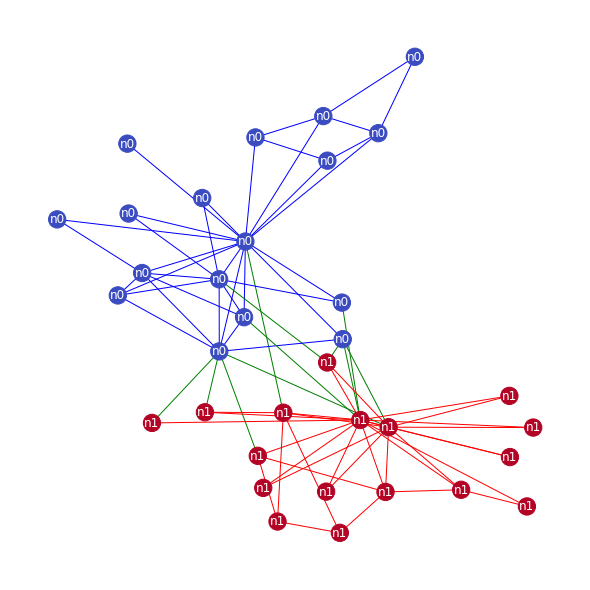

In [3]:
import torch

community_node = dict((k, "n" + str(v)) for k, v in community_map.items()) # {0: 'n0', 1: 'n0', etc..}
node_feature = dict(((node, torch.tensor([1, 1, 1, 1, 1.])) for node in G.nodes())) # {0: [1,1,1,1,1] etc..}
node_label = dict((node[0], 0) if node[1]['club'] == 'Mr. Hi' else (node[0], 1) for node in G.nodes(data=True)) # {0:1, 1:1, etc..}
nx.classes.function.set_node_attributes(G, community_node, name='node_type')
nx.classes.function.set_node_attributes(G, node_feature, name='node_feature')
nx.classes.function.set_node_attributes(G, node_label, name='node_label')
community_edge = {} # {(a, b): e0, etc..}
edge_color = {}
for edge in G.edges():
    n1, n2 = edge
    community_edge[edge] = 'e' + str(community_map[n1]) if community_map[n1] == community_map[n2] else 'e2'
    edge_color[edge] = community_map[n1] if community_map[n1] == community_map[n2] else 2
    if community_map[n1] == community_map[n2] and community_map[n1] == 0:
        edge_color[edge] = 'blue'
    elif community_map[n1] == community_map[n2] and community_map[n1] == 1:
        edge_color[edge] = 'red'
    else:
        edge_color[edge] = 'green'
nx.classes.function.set_edge_attributes(G, community_edge, name='edge_type')
G_orig = copy.deepcopy(G)
nx.classes.function.set_edge_attributes(G, edge_color, name='color')
colors = nx.get_edge_attributes(G, 'color').values()
for edge in G.edges(data=True):
    del edge[2]['color']
for node in G.nodes(data=True):
    print(node)
    break
for edge in G.edges(data=True):
    print(edge)
    break
labels = nx.get_node_attributes(G, 'node_type')
plt.figure(figsize=(8, 8))
nx.draw(G, pos=pos, cmap=plt.get_cmap('coolwarm'), node_color=node_color, edge_color=colors, labels=labels, font_color='white')
show()

## Transform to DeepSNAP Heterogeneous Graph

Transform the karate club heterogeneous graph into `deepsnap.hetero_graph.HeteroGraph`.

After the transformation, the `node_feature` and `node_label` tensors will be created and referenced in the `hetero_graph` object.

In [14]:
from deepsnap.hetero_graph import HeteroGraph

hetero = HeteroGraph(G_orig)
for edge in G_orig.edges(data=True):
    print(edge)
    break
print("Node types: {}".format(hetero.node_types))
print("Edge types: {}".format(hetero.edge_types))
print("Message types: {}".format(hetero.message_types))
for node_type in hetero.node_types:
    print("Node type {} has {} nodes".format(node_type, hetero.num_nodes(node_type)))
for message_type in hetero.message_types:
    print("Message type {} has {} edges".format(message_type, hetero.num_edges(message_type)))
print(hetero.node_feature)
print(hetero.node_label)

(0, 1, {'edge_type': 'e0'})
Node types: ['n0', 'n1']
Edge types: ['e1', 'e0', 'e2']
Message types: [('n0', 'e0', 'n0'), ('n0', 'e2', 'n1'), ('n1', 'e1', 'n1')]
Node type n0 has 17 nodes
Node type n1 has 17 nodes
Message type ('n0', 'e0', 'n0') has 35 edges
Message type ('n0', 'e2', 'n1') has 11 edges
Message type ('n1', 'e1', 'n1') has 32 edges
{'n0': tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]]), 'n1': tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        

## Node Classification Split

In addition, we will split the DeepSNAP heterogeneous graph into three sets (train, validation and test) with the ratio 4 : 3: 3 on the node classification task.

The following plottings show which nodes are in each dataset. The grey nodes mean that they are not in the corresponding dataset. The blue `n0` nodes and red `n1` nodes indicate that they appear in corresponding dataset.

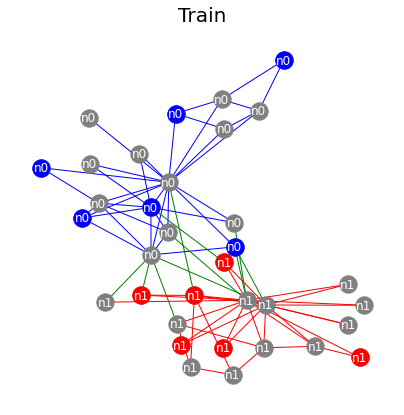

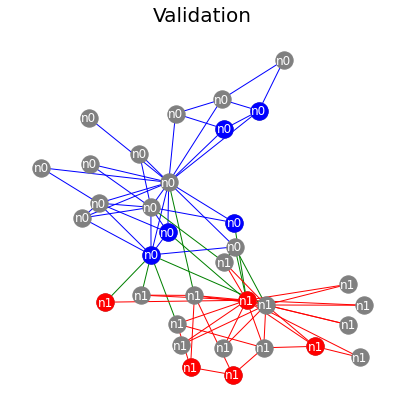

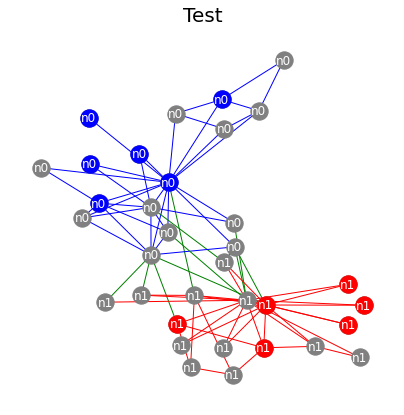

In [20]:
from deepsnap.dataset import GraphDataset

dataset = GraphDataset([hetero], task='node')
# Splitting the dataset
dataset_train, dataset_val, dataset_test = dataset.split(transductive=True, split_ratio=[0.4, 0.3, 0.3])
titles = ['Train', 'Validation', 'Test']

for i, dataset in enumerate([dataset_train, dataset_val, dataset_test]):
    n0 = hetero._convert_to_graph_index(dataset[0].node_label_index['n0'], 'n0').tolist()
    n1 = hetero._convert_to_graph_index(dataset[0].node_label_index['n1'], 'n1').tolist()

    plt.figure(figsize=(7, 7))
    plt.title(titles[i], fontsize=20)
    nx.draw(G_orig, pos=pos, node_color="grey", edge_color=colors, labels=labels, font_color='white')
    nx.draw_networkx_nodes(G_orig.subgraph(n0), pos=pos, node_color="blue")
    nx.draw_networkx_nodes(G_orig.subgraph(n1), pos=pos, node_color="red")
    show()

## Link Prediction Split

The following shows that in the link predictino task how the different edge types are splitted into train, test and validation sets by message type.

If the edge appears in one splitted set, it will be assigned with blue, red, or green. Else the edge will be in grey.

/usr/local/lib/python3.7/dist-packages/deepsnap/hetero_graph.py:3138: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row[message_type] = perm[message_type] // num_nodes[tail_type]


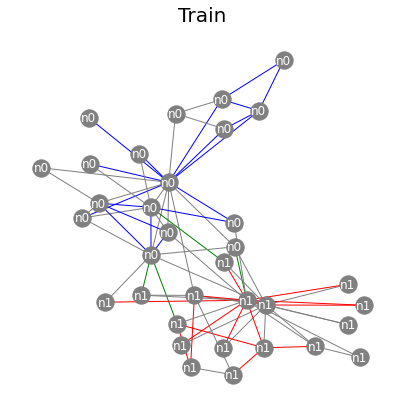

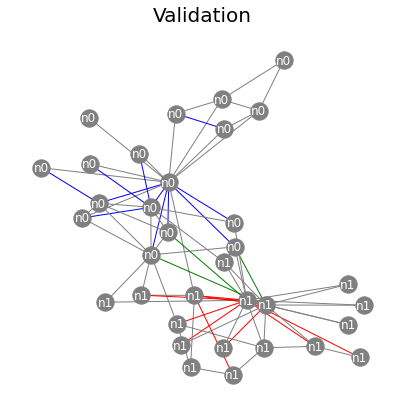

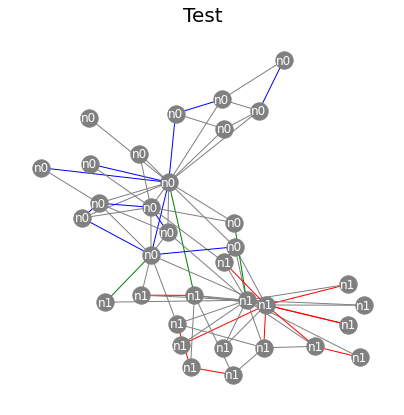

In [21]:
import copy

dataset = GraphDataset([hetero], task='link_pred')
dataset_train, dataset_val, dataset_test = dataset.split(transductive=True, split_ratio=[0.4, 0.3, 0.3])
titles = ['Train', 'Validation', 'Test']

for i, dataset in enumerate([dataset_train, dataset_val, dataset_test]):
    edge_color_dataset = {}
    for edge in G_orig.edges():
        n1, n2 = edge
        edge_color_dataset[edge] = "grey"
    for message_type in dataset[0].edge_label_index:
        if message_type[0] == 'n0' and message_type[2] == 'n0':
            from_nodes = hetero._convert_to_graph_index(dataset[0].edge_label_index[('n0', 'e0', 'n0')][0], 'n0')
            to_nodes = hetero._convert_to_graph_index(dataset[0].edge_label_index[('n0', 'e0', 'n0')][1], 'n0')
        elif message_type[0] == 'n1' and message_type[2] == 'n1':
            from_nodes = hetero._convert_to_graph_index(dataset[0].edge_label_index[('n1', 'e1', 'n1')][0], 'n1')
            to_nodes = hetero._convert_to_graph_index(dataset[0].edge_label_index[('n1', 'e1', 'n1')][1], 'n1')
        else:
            from_nodes = hetero._convert_to_graph_index(dataset[0].edge_label_index[('n0', 'e2', 'n1')][0], 'n0')
            to_nodes = hetero._convert_to_graph_index(dataset[0].edge_label_index[('n0', 'e2', 'n1')][1], 'n1')
        for j in range(len(from_nodes)):
            edge = (from_nodes[j].item(), to_nodes[j].item())
            if G.has_edge(edge[0], edge[1]):
                if message_type[0] == 'n0' and message_type[2] == 'n0':
                    edge_color_dataset[edge] = 'blue'
                elif message_type[0] == 'n1' and message_type[2] == 'n1':
                    edge_color_dataset[edge] = 'red'
                else:
                    edge_color_dataset[edge] = 'green'
    H = copy.deepcopy(G_orig)
    nx.classes.function.set_edge_attributes(H, edge_color_dataset, name='color_dataset')
    edge_color_dataset = nx.get_edge_attributes(H, 'color_dataset').values()
    plt.figure(figsize=(7, 7))
    plt.title(titles[i], fontsize=20)
    nx.draw(H, pos=pos, node_color="grey", edge_color=edge_color_dataset, labels=labels, font_color='white')
    show()

# A Simple Heterogeneous Link Prediction Example using DeepSNAP

Following is a simple example on a heterogeneous link prediction task (`WN18`) using the DeepSNAP.

## Dataset

Lets download the `WN18` dataset.

In [22]:
!wget https://www.dropbox.com/s/gb6b3fixmaadltu/WN18.gpickle

--2022-05-23 23:45:06--  https://www.dropbox.com/s/gb6b3fixmaadltu/WN18.gpickle
Resolving www.dropbox.com (www.dropbox.com)... 162.125.9.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.9.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/gb6b3fixmaadltu/WN18.gpickle [following]
--2022-05-23 23:45:07--  https://www.dropbox.com/s/raw/gb6b3fixmaadltu/WN18.gpickle
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc9392983ddf70133aacbe01c080.dl.dropboxusercontent.com/cd/0/inline/Bl1ZvDOAt9fZ33Loh_WsAEdxD04NHVF7IIK2tF_j1JU-GqiRi7tpU6o-KIoIkbkDpCXHrYaqU2boSTWOqU6RWXnqxJteCQIYott4lje4U5c_GG6e_hxju0PiYSfxZTMkzEfGuDAeQVsGBtZ40sJLZ4dbb1K3KAzcNI92w0fOBYiKpw/file# [following]
--2022-05-23 23:45:07--  https://uc9392983ddf70133aacbe01c080.dl.dropboxusercontent.com/cd/0/inline/Bl1ZvDOAt9fZ33Loh_WsAEdxD04NHVF7IIK2tF_j1JU-GqiRi7tpU6o-KIoIkbkDpCXH

In this dataset, we set `node_feature` tensor with all ones and dimension 5. Here, we print out an overview of the node and edge attributes.

In [23]:
G = nx.read_gpickle("WN18.gpickle")
for node in G.nodes(data=True):
    print(node)
    break
for edge in G.edges(data=True):
    print(edge)
    break
print("Number of edges is {}".format(G.number_of_edges()))
print("Number of nodes is {}".format(G.number_of_nodes()))

(0, {'node_type': 'n1', 'node_feature': tensor([1., 1., 1., 1., 1.])})
(0, 1, {'edge_feature': tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'edge_type': '0'})
Number of edges is 141442
Number of nodes is 41105


## Generate Heterogeneous GNN Layers

At first, let's generate heterogeneous GNN layers. Each GNN layer is a dictionary that the key is the message type which is in the tuple of `(node_type_1, edge_type, node_type_2)`. This means that the information will be passed through each message type. The value is the initialized heterogeneous GNN layer such as `HeteroSAGEConv`.

In [24]:
# Functions to generate two internal GNN layers for link prediction task
def generate_2convs_link_pred_layers(hete, conv, hidden_size):
    convs1 = {}
    convs2 = {}
    for message_type in hete.message_types:
        n_type = message_type[0]
        s_type = message_type[2]
        n_feat_dim = hete.num_node_features(n_type)
        s_feat_dim = hete.num_node_features(s_type)
        convs1[message_type] = conv(n_feat_dim, hidden_size, s_feat_dim)
        convs2[message_type] = conv(hidden_size, hidden_size, hidden_size)
    return convs1, convs2

Now, let's generate the layers and load the data to dataloader.

In [25]:
from pprint import pprint
from deepsnap.hetero_graph import HeteroGraph
from deepsnap.dataset import GraphDataset
from deepsnap.batch import Batch
from deepsnap.hetero_gnn import HeteroSAGEConv
from torch.utils.data import DataLoader

hetero = HeteroGraph(G)
hidden_size = 32

# Generate two heterogeneous GNN layers for link prediction
conv1, conv2 = generate_2convs_link_pred_layers(hetero, HeteroSAGEConv, hidden_size)
pprint(conv1) # maps different message types to heterosageconv
pprint(conv2) # create a convolution layer for reach edge type

dataset = GraphDataset([hetero], task='link_pred')
dataset_train, dataset_val, dataset_test = dataset.split(transductive=True,
                                                        split_ratio=[0.8, 0.1, 0.1])
train_loader = DataLoader(dataset_train, collate_fn=Batch.collate(),
                    batch_size=1)
val_loader = DataLoader(dataset_val, collate_fn=Batch.collate(),
                    batch_size=1)
test_loader = DataLoader(dataset_test, collate_fn=Batch.collate(),
                    batch_size=1)
dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}

{('n1', '0', 'n1'): HeteroSAGEConv(neigh: 5, self: 5, out: 32),
 ('n1', '1', 'n1'): HeteroSAGEConv(neigh: 5, self: 5, out: 32),
 ('n1', '10', 'n1'): HeteroSAGEConv(neigh: 5, self: 5, out: 32),
 ('n1', '11', 'n1'): HeteroSAGEConv(neigh: 5, self: 5, out: 32),
 ('n1', '12', 'n1'): HeteroSAGEConv(neigh: 5, self: 5, out: 32),
 ('n1', '13', 'n1'): HeteroSAGEConv(neigh: 5, self: 5, out: 32),
 ('n1', '14', 'n1'): HeteroSAGEConv(neigh: 5, self: 5, out: 32),
 ('n1', '15', 'n1'): HeteroSAGEConv(neigh: 5, self: 5, out: 32),
 ('n1', '16', 'n1'): HeteroSAGEConv(neigh: 5, self: 5, out: 32),
 ('n1', '17', 'n1'): HeteroSAGEConv(neigh: 5, self: 5, out: 32),
 ('n1', '2', 'n1'): HeteroSAGEConv(neigh: 5, self: 5, out: 32),
 ('n1', '3', 'n1'): HeteroSAGEConv(neigh: 5, self: 5, out: 32),
 ('n1', '4', 'n1'): HeteroSAGEConv(neigh: 5, self: 5, out: 32),
 ('n1', '5', 'n1'): HeteroSAGEConv(neigh: 5, self: 5, out: 32),
 ('n1', '6', 'n1'): HeteroSAGEConv(neigh: 5, self: 5, out: 32),
 ('n1', '7', 'n1'): HeteroSAGECo

/usr/local/lib/python3.7/dist-packages/deepsnap/hetero_graph.py:3138: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row[message_type] = perm[message_type] // num_nodes[tail_type]


## HeteroGNN

In the next, we will implement the `HeteroGNN`.

* We need to pass each of the heterogeneous GNN layers to the `HeteroConv` wrapper layer and generate the heterogeneous layers we can use.
* We need to implement the `forward` function for the `HeteroGNN`. Notice that the `node_feature` and the returned value of the wrapper GNN layers is in format of dictionary that the key is the `node_type` and value is its corresponding embedding tensor. So, adding the nonlinear activation or apply `dropout` layers also need to loop through the dictionary. We provide helper function such as the `deepsnap.hetero_gnn.forward_op` will automatically loop through the dictionary.

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from deepsnap.hetero_gnn import forward_op, HeteroConv

# Define the heterogeneous GNN for the link prediction task
class HeteroGNN(torch.nn.Module):
    def __init__(self, conv1, conv2, hetero, hidden_size):
        super(HeteroGNN, self).__init__()
        
        self.convs1 = HeteroConv(conv1) # Wrap the heterogeneous GNN layers
        self.convs2 = HeteroConv(conv2)
        self.loss_fn = torch.nn.BCEWithLogitsLoss()
        self.bns1 = nn.ModuleDict()
        self.bns2 = nn.ModuleDict()
        self.relus1 = nn.ModuleDict()
        self.relus2 = nn.ModuleDict()
        self.post_mps = nn.ModuleDict()

        for node_type in hetero.node_types:
            self.bns1[node_type] = torch.nn.BatchNorm1d(hidden_size)
            self.bns2[node_type] = torch.nn.BatchNorm1d(hidden_size)
            self.relus1[node_type] = nn.LeakyReLU()
            self.relus2[node_type] = nn.LeakyReLU()

    def forward(self, data):
        x = data.node_feature
        edge_index = data.edge_index
        x = self.convs1(x, edge_index)
        x = forward_op(x, self.bns1)
        x = forward_op(x, self.relus1)
        x = self.convs2(x, edge_index)
        x = forward_op(x, self.bns2)

        pred = {}
        for message_type in data.edge_label_index:
            nodes_first = torch.index_select(x['n1'], 0, data.edge_label_index[message_type][0,:].long())
            nodes_second = torch.index_select(x['n1'], 0, data.edge_label_index[message_type][1,:].long())
            pred[message_type] = torch.sum(nodes_first * nodes_second, dim=-1)
        return pred

    def loss(self, pred, y):
        loss = 0
        for key in pred:
            p = torch.sigmoid(pred[key])
            loss += self.loss_fn(p, y[key].type(pred[key].dtype))
        return loss

We implement the training and testing functions as follows.

In [44]:
import numpy as np
import copy

# Train function
def train(model, dataloaders, optimizer, args):
    val_max = 0
    best_model = model
    t_accu = []
    v_accu = []
    e_accu = []
    for epoch in range(1, args["epochs"] + 1):
        for iter_i, batch in enumerate(dataloaders['train']):
            batch.to(args["device"])
            model.train()
            optimizer.zero_grad()
            pred = model(batch)
            loss = model.loss(pred, batch.edge_label)
            loss.backward()
            optimizer.step()

            log = 'Epoch: {:03d}, Train loss: {:.4f}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'
            accs = test(model, dataloaders, args)
            t_accu.append(accs['train'])
            v_accu.append(accs['val'])
            e_accu.append(accs['test'])

            print(log.format(epoch, loss.item(), accs['train'], accs['val'], accs['test']))
            if val_max < accs['val']:
                val_max = accs['val']
                best_model = copy.deepcopy(model)

    log = 'Best: Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'
    accs = test(best_model, dataloaders, args)
    print(log.format(accs['train'], accs['val'], accs['test']))

    return t_accu, v_accu, e_accu

# Test function
def test(model, dataloaders, args):
    model.eval()
    accs = {}
    for mode, dataloader in dataloaders.items():
        acc = 0
        for i, batch in enumerate(dataloader):
            num = 0
            batch.to(args["device"])
            pred = model(batch)
            for key in pred:
                p = torch.sigmoid(pred[key]).cpu().detach().numpy()
                pred_label = np.zeros_like(p, dtype=np.int64)
                pred_label[np.where(p > 0.5)[0]] = 1
                pred_label[np.where(p <= 0.5)[0]] = 0
                acc += np.sum(pred_label == batch.edge_label[key].cpu().numpy())
                num += len(pred_label)
        accs[mode] = acc / num
    return accs

## Start Training!

In [45]:
args = {
    "device": "cpu",
    "epochs": 50,
    "lr": 0.01,
    "weight_decay": 1e-4
}

# Build the model and start training
model = HeteroGNN(conv1, conv2, hetero, hidden_size).to(args["device"])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])
t_accu, v_accu, e_accu = train(model, dataloaders, optimizer, args)

/usr/local/lib/python3.7/dist-packages/deepsnap/hetero_graph.py:3138: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row[message_type] = perm[message_type] // num_nodes[tail_type]


Epoch: 001, Train loss: 12.9928, Train: 0.5017, Val: 0.4879, Test: 0.4946
Epoch: 002, Train loss: 12.4965, Train: 0.4965, Val: 0.4717, Test: 0.4863
Epoch: 003, Train loss: 12.1559, Train: 0.5281, Val: 0.4878, Test: 0.5057
Epoch: 004, Train loss: 12.0409, Train: 0.5550, Val: 0.5235, Test: 0.5460
Epoch: 005, Train loss: 11.9188, Train: 0.5837, Val: 0.5569, Test: 0.5803
Epoch: 006, Train loss: 11.8685, Train: 0.6178, Val: 0.5843, Test: 0.6101
Epoch: 007, Train loss: 11.8131, Train: 0.6444, Val: 0.6078, Test: 0.6323
Epoch: 008, Train loss: 11.7971, Train: 0.6666, Val: 0.6285, Test: 0.6492
Epoch: 009, Train loss: 11.7213, Train: 0.6892, Val: 0.6418, Test: 0.6625
Epoch: 010, Train loss: 11.7235, Train: 0.6992, Val: 0.6504, Test: 0.6697
Epoch: 011, Train loss: 11.6884, Train: 0.6992, Val: 0.6517, Test: 0.6733
Epoch: 012, Train loss: 11.6333, Train: 0.6984, Val: 0.6550, Test: 0.6787
Epoch: 013, Train loss: 11.6208, Train: 0.6961, Val: 0.6526, Test: 0.6777
Epoch: 014, Train loss: 11.5899, Train

More examples for DeepSNAP heterogeneous graph usage please see the [examples](https://github.com/snap-stanford/deepsnap/tree/master/examples) folder.

[Next: Heterogeneous Node Classification with DeepSNAP](https://colab.research.google.com/drive/1L-0kaLqeiT6lHhjHxAzP5sHIcb4b4e7G?usp=sharing).